In [36]:
import os
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms

#For converting the dataset to torchvision dataset format
class VowelConsonantDataset(Dataset):
    def __init__(self, file_path,train=True,transform=None):
        self.transform = transform
        self.file_path=file_path
        self.train=train
        self.file_names=[file for _,_,files in os.walk(self.file_path) for file in files]
        self.len = len(self.file_names)
        if self.train:
            self.classes_mapping=self.get_classes()
    def __len__(self):
        return len(self.file_names)
    
    def __getitem__(self, index):
        file_name=self.file_names[index]
        image_data=self.pil_loader(self.file_path+"/"+file_name)
        if self.transform:
            image_data = self.transform(image_data)
        if self.train:
            file_name_splitted=file_name.split("_")
            Y1 = self.classes_mapping[file_name_splitted[0]]
            Y2 = self.classes_mapping[file_name_splitted[1]]
            z1,z2=torch.zeros(10),torch.zeros(10)
            z1[Y1-10],z2[Y2]=1,1
            label=torch.stack([z1,z2])

            return image_data, label

        else:
            return image_data, file_name
          
    def pil_loader(self,path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

      
    def get_classes(self):
        classes=[]
        for name in self.file_names:
            name_splitted=name.split("_")
            classes.extend([name_splitted[0],name_splitted[1]])
        classes=list(set(classes))
        classes_mapping={}
        for i,cl in enumerate(sorted(classes)):
            classes_mapping[cl]=i
        return classes_mapping
    

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets

import torchvision.transforms as transforms

import numpy as np
import pandas as pd

train_on_gpu = torch.cuda.is_available()

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
!mkdir -p hin_classifier
!unzip -nq "/content/drive/My Drive/hin_classifier/train.zip" -d hin_classifier
!unzip -nq "/content/drive/My Drive/hin_classifier/test.zip" -d hin_classifier

In [40]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [41]:
transform = transforms.Compose([
    transforms.ToTensor()])

In [42]:
full_data = VowelConsonantDataset("hin_classifier/train",train=True,transform=transform)
train_size = int(0.9 * len(full_data))
test_size = len(full_data) - train_size

train_data, validation_data = random_split(full_data, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=60, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=60, shuffle=True)

In [43]:
test_data = VowelConsonantDataset("hin_classifier/test",train=False,transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=60,shuffle=False)

In [44]:
def label_tensor(actual_labels):
    return torch.LongTensor([torch.max(labels, dim = -1)[1].item() for labels in actual_labels])

In [45]:
class FeedForwardNetwork(nn.Module):
    def __init__(self): 
        super(FeedForwardNetwork, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(12288, 2),  # 64 x 64 x 3 = 12288
            nn.ReLU(),
            nn.Linear(2, 2),
            nn.ReLU(),
            nn.Linear(2, 10)
        )
             
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [55]:
def train(network, optimise, epochs, compute_loss, loss_recorder=[]):
    for epoch in range(epochs):

        for i, data in enumerate(train_loader, 0):

            inputs, labels = data
            inputs = inputs.to(device)
            
            optimise.zero_grad()

            outputs = network(inputs)

            labels_reshaped = labels.permute(1,0,2)
            vow_labels = label_tensor(labels_reshaped[0])
            con_labels = label_tensor(labels_reshaped[1])
            vow_labels = vow_labels.to(device)
            con_labels = con_labels.to(device)

            loss = compute_loss(outputs, vow_labels)
            loss += compute_loss(outputs, con_labels)
            loss.backward()
            optimise.step()
        loss_recorder.append(loss.item())    
        print('Epoch: %d/%d' % (epoch, max_epochs))


In [52]:
def plot_loss(loss_recorder):
    plt.plot(loss_epoch_arr)
    plt.show()

In [53]:
max_epochs = 16 if torch.cuda.is_available() else 5

In [56]:
%%time
ffn = FeedForwardNetwork().to(device)
loss_epoch_arr = []
train(ffn, optim.SGD(ffn.parameters(), lr=0.01), max_epochs,nn.CrossEntropyLoss(), loss_epoch_arr)

Epoch: 0/16
Epoch: 1/16
Epoch: 2/16
Epoch: 3/16
Epoch: 4/16
Epoch: 5/16
Epoch: 6/16
Epoch: 7/16
Epoch: 8/16
Epoch: 9/16
Epoch: 10/16
Epoch: 11/16
Epoch: 12/16
Epoch: 13/16
Epoch: 14/16
Epoch: 15/16
CPU times: user 1min 29s, sys: 4.28 s, total: 1min 34s
Wall time: 1min 34s


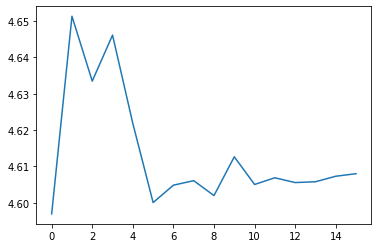

In [57]:
plot_loss(loss_epoch_arr)